## Notes to self about GANs

Everything is based off this link [Machine Learning Mastery's GAN 1D function](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/)

### Mistake I made: (mode collapse, but not really)

I noticed that my generator would generate the same or close to the same point over time. I looked around saw that this was called [mode collapse](https://medium.com/@jonathan_hui/gan-why-it-is-so-hard-to-train-generative-advisory-networks-819a86b3750b). 

However, this was simply due to my not training my generator correctly. Explained at the bottom

### Discriminator: 
Input: Predicted example 

Output: T/F


### Generator: 
Input: Latent variables 

Output: Predicted example 


### Overall GAN model: 
 Generator -> Discriminator 
 
 Input: Latent Variables 
 
 Output: T/F  
        
### Just Generator: 

Input: Latent Variables 

Output: [x1,x2]


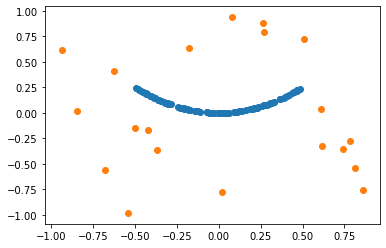

In [11]:
%matplotlib inline
import numpy as np 
from matplotlib import pyplot
np.random.seed(42)

def f(x):
    return x*x

def generate_real_data(n_samples):
    x = np.random.rand(n_samples,1) - 0.5
    y = x*x
    return np.concatenate((x, y), axis=1)

def generate_random_data (n_samples):
    X1 = -1 + np.random.rand(n_samples) * 2
    # generate outputs in [-1, 1]
    X2 = -1 + np.random.rand(n_samples) * 2
    # stack arrays
    X1 = X1.reshape(n_samples, 1)
    X2 = X2.reshape(n_samples, 1)
    X = np.hstack((X1, X2))
    return X

r = generate_real_data(100)
f = generate_random_data(20)

pyplot.scatter(r[:,0], r[:,1])
pyplot.scatter(f[:,0], f[:,1])
pyplot.show()

Here we want to create real $x^{2}$ and random data and plot them. This will be used to train the discriminator

In [12]:
from keras.models import Sequential
from keras.layers import Dense

def create_discriminator():
    model = Sequential()
    model.add(Dense(25, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def train_discriminator(model, n_epochs = 1000, half_n_samples = 128):
    for i in range(n_epochs):
        real_x = generate_real_data(half_n_samples)
        fake_x = generate_random_data(half_n_samples)
        real_y = np.ones((half_n_samples,1))
        fake_y = np.zeros((half_n_samples,1))
        _, acc_real = model.train_on_batch(real_x, real_y)
        _, acc_fake = model.train_on_batch(fake_x, fake_y)
    return acc_real, acc_fake

model = create_discriminator()
model.summary()
acc_real, acc_fake = train_discriminator(model)
print (acc_real, ' ', acc_fake)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 25)                75        
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 26        
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
1.0   0.8984375


In [13]:
def create_generator(latent_dim = 15, input_dim = 5, output_dim= 2):
    model = Sequential()
    model.add(Dense(latent_dim, input_dim=input_dim, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(output_dim, activation='linear'))
    return model

model = create_generator()
model.summary()

def create_latent_input(n_samples, latent_dim=5):
    return np.random.rand(n_samples, latent_dim)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 15)                90        
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 32        
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________


In [14]:
def create_gan(discriminator, generator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile (loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return model

discriminator = create_discriminator()
generator = create_generator()
gan = create_gan(discriminator, generator)
gan.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_13 (Sequential)   (None, 2)                 122       
_________________________________________________________________
sequential_12 (Sequential)   (None, 1)                 101       
Total params: 223
Trainable params: 122
Non-trainable params: 101
_________________________________________________________________


0 0  discriminator acc:  0.390625   0.703125


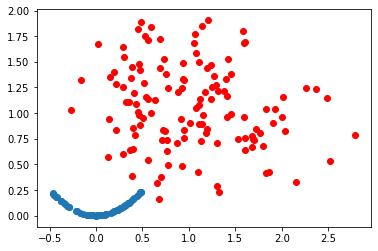

1000 1000  discriminator acc:  0.359375   1.0


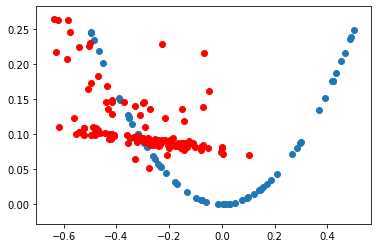

2000 2000  discriminator acc:  0.390625   0.0


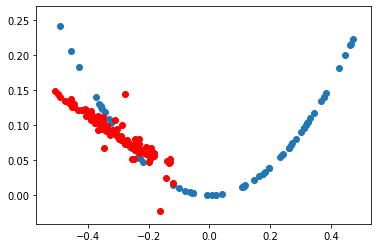

3000 3000  discriminator acc:  0.25   0.15625


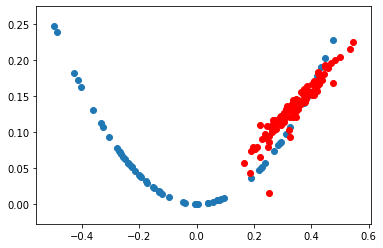

4000 4000  discriminator acc:  0.359375   1.0


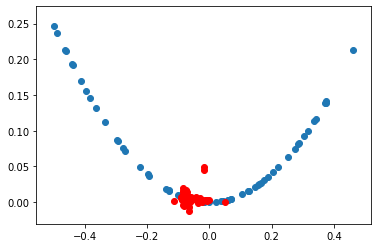

5000 5000  discriminator acc:  0.46875   1.0


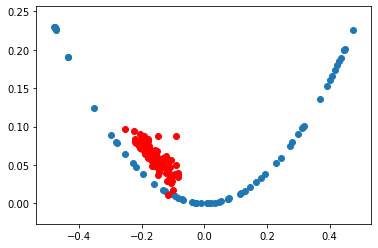

6000 6000  discriminator acc:  0.546875   1.0


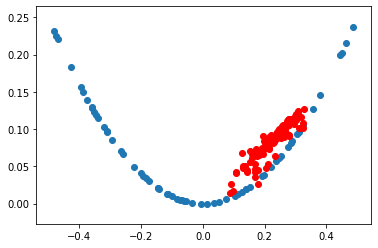

7000 7000  discriminator acc:  0.640625   1.0


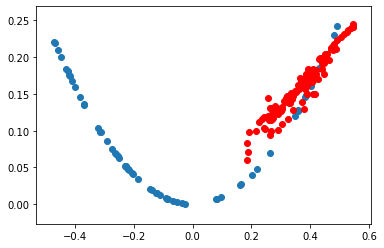

8000 8000  discriminator acc:  0.484375   1.0


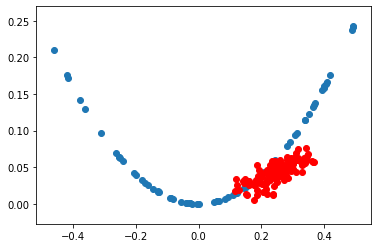

9000 9000  discriminator acc:  0.59375   1.0


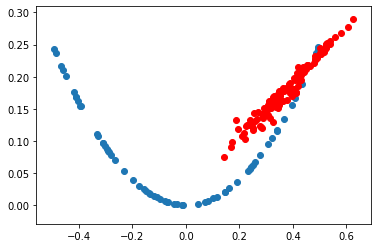

In [17]:
from matplotlib import pyplot

def train_gan(gan, discriminator, generator, epochs = 20000):
    n_samples = 128 
    for epoch in range (epochs):
        half_n_samples = n_samples//2
        # train discriminator
        real_x = generate_real_data(half_n_samples)
        fake_x = generate_random_data(half_n_samples) # ISSUE IS HERE!!!
        y_fake = np.zeros((half_batch,1))
        real_y = np.ones((half_n_samples,1))
        fake_y = np.zeros((half_n_samples,1))
        _, acc_real = discriminator.train_on_batch(real_x, real_y)
        _, acc_fake = discriminator.train_on_batch(fake_x, fake_y)            
        
        # create latent input 
        x_gan = create_latent_input(n_samples)
        y_gan = np.ones((n_samples,1))
        gan.train_on_batch(x_gan, y_gan)

        if epoch % 1000 == 0:
            print (epoch, end = ' ')
            print (epoch, ' discriminator acc: ', acc_real, ' ', acc_fake)
            x_gan2 = create_latent_input(n_samples)
            fake_points = generator.predict(x_gan2)
            pyplot.scatter(real_x[:,0], real_x[:,1])
            pyplot.scatter(fake_points[:, 0], fake_points[:, 1], color='red')
            pyplot.show()
            
discriminator = create_discriminator()
# create the generator
generator = create_generator()
# create the gan
gan = create_gan(discriminator, generator)
train_gan(gan, discriminator, generator)

# Mistake I made due to misunderstanding


```fake_x = generate_random_data(half_n_samples)```

Where I randomy generate points, and NOT from my generator... I needed to add a function ```generate_fake_input``` (implemented below)

In [18]:
def generate_fake_input(generator, n_samples):
    x = create_latent_input(n_samples)
    return generator.predict(x)

print (generate_fake_input(generator, 5))

[[-0.42739168  0.20302844]
 [-0.40602067  0.19912869]
 [-0.42699528  0.18401563]
 [-0.31247357  0.14031701]
 [-0.28132454  0.13445884]]


0 0  discriminator acc:  1.0   0.0


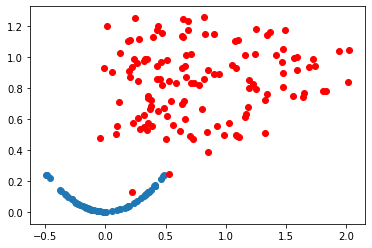

1000 1000  discriminator acc:  0.84375   0.3125


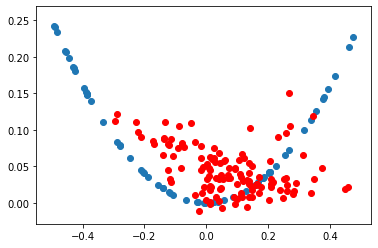

2000 2000  discriminator acc:  0.46875   0.0


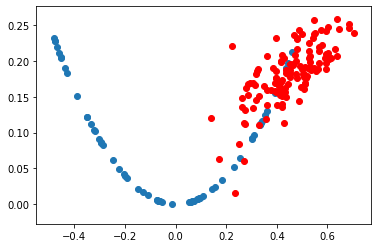

3000 3000  discriminator acc:  0.0   1.0


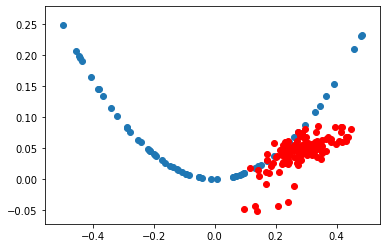

4000 4000  discriminator acc:  0.4375   1.0


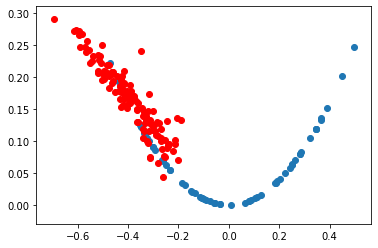

5000 5000  discriminator acc:  0.375   0.0


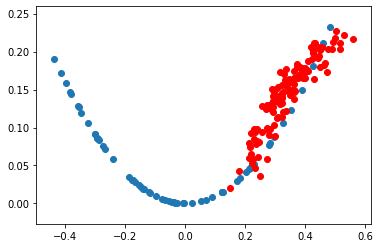

6000 6000  discriminator acc:  0.609375   0.078125


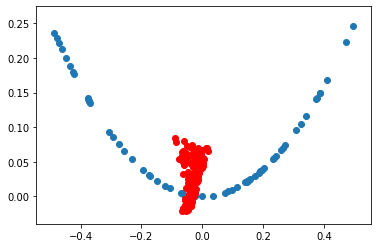

7000 7000  discriminator acc:  0.484375   1.0


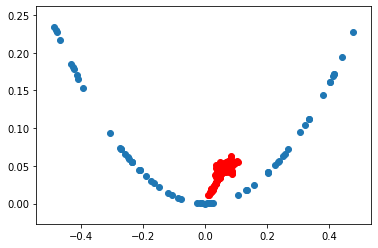

8000 8000  discriminator acc:  0.34375   1.0


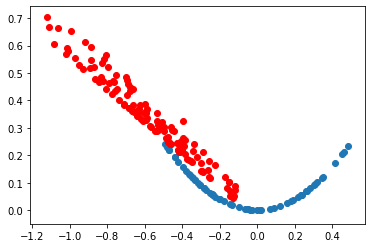

9000 9000  discriminator acc:  0.375   1.0


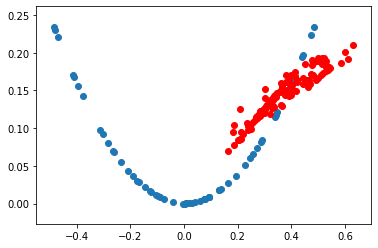

10000 10000  discriminator acc:  0.640625   0.0


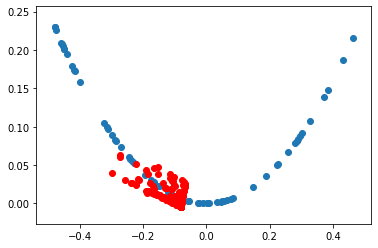

11000 11000  discriminator acc:  0.5625   1.0


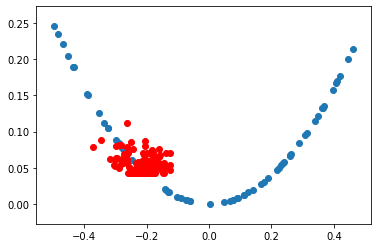

12000 12000  discriminator acc:  0.578125   1.0


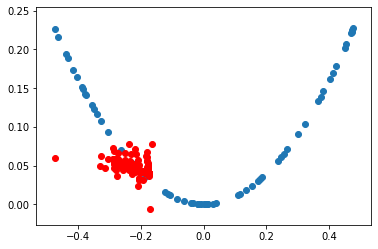

13000 13000  discriminator acc:  0.53125   0.890625


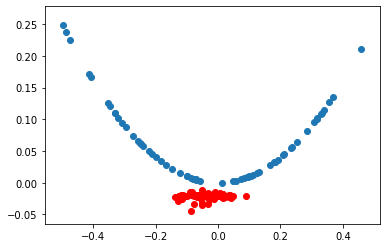

14000 14000  discriminator acc:  0.296875   0.421875


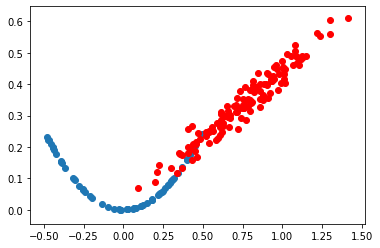

15000 15000  discriminator acc:  0.15625   1.0


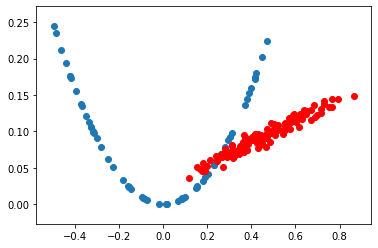

16000 16000  discriminator acc:  0.453125   1.0


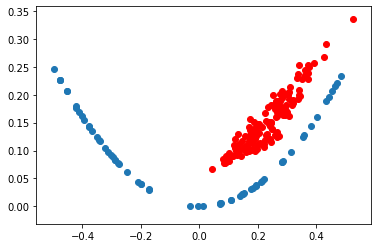

17000 17000  discriminator acc:  0.625   0.578125


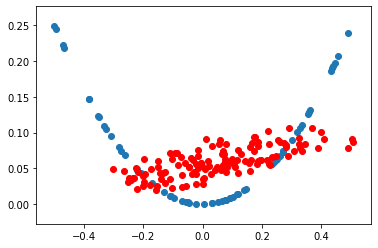

18000 18000  discriminator acc:  0.25   0.75


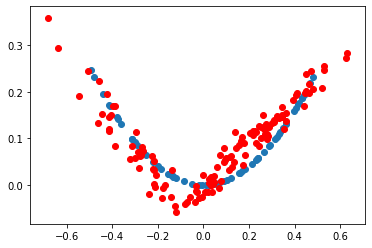

19000 19000  discriminator acc:  0.515625   0.65625


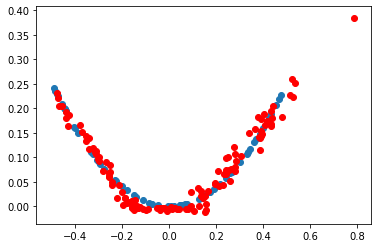

In [20]:
from matplotlib import pyplot

def train_gan(gan, discriminator, generator, epochs = 20000):
    n_samples = 128 
    for epoch in range (epochs):
        half_n_samples = n_samples//2
        # train discriminator
        real_x = generate_real_data(half_n_samples)
        fake_x = generate_fake_input(generator, half_n_samples)        
        real_y = np.ones((half_n_samples,1))
        fake_y = np.zeros((half_n_samples,1))
        _, acc_real = discriminator.train_on_batch(real_x, real_y)
        _, acc_fake = discriminator.train_on_batch(fake_x, fake_y)            
        
        # create latent input
        x_gan = create_latent_input(n_samples)
        y_gan = np.ones((n_samples,1))
        gan.train_on_batch(x_gan, y_gan)

        if epoch % 1000 == 0:
            print (epoch, end = ' ')
            print (epoch, ' discriminator acc: ', acc_real, ' ', acc_fake)
            x_gan2 = create_latent_input(n_samples)
            fake_points = generator.predict(x_gan2)
            pyplot.scatter(real_x[:,0], real_x[:,1])
            pyplot.scatter(fake_points[:, 0], fake_points[:, 1], color='red')
            pyplot.show()
            
discriminator = create_discriminator()
# create the generator
generator = create_generator()
# create the gan
gan = create_gan(discriminator, generator)
train_gan(gan, discriminator, generator)

## Conclusion

And now we got the discriminator's real and fake accuracy down to ~51% and ~65% respectively. 

Mistake was how the generator wasn't really learning as much and the discriminator kept learning more off the generated random data. This was a my mistake. 